In [53]:
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import acquire
import prepare
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


## Data Wrangling:
### Data acquisiton

I want to identify variables that may contribute to churn and implement either the decision tree, random forest, or k nearest neighbor machine learning model to help predict which customers will churn.

first I need to acquire the data from the database.

In [54]:
# the following functions are already defined in the acquire.py file
# this function acquires the telco dataset from the SQL server utilising the host, username, and password in the env.py file
def new_telco_data():
   
    sql_query = """
                select * from customers
                join contract_types using (contract_type_id)
                join internet_service_types using (internet_service_type_id)
                join payment_types using (payment_type_id)
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('telco_churn'))
    
    return df
# this function checks for a CSV file cached locally first, then will run new_telco_data to acquire the dataset if it does not exist locally
def get_telco_data():
    
    if os.path.isfile('telco.csv'):
        
        # If csv file exists read in data from csv file.
        df = pd.read_csv('telco.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame
        df = new_telco_data()
        
        # Cache data
        df.to_csv('telco.csv')
        
    return df
df = acquire.get_telco_data()

In [3]:
#checking the data information to identify potential problems early
df.head()


,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,2,0002-ORFBO,Female,0,Yes,Yes,9,Yes,...,Yes,Yes,No,Yes,65.6,593.3,No,One year,DSL,Mailed check
1,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,Month-to-month,DSL,Mailed check
2,1,2,1,0004-TLHLJ,Male,0,No,No,4,Yes,...,No,No,No,Yes,73.9,280.85,Yes,Month-to-month,Fiber optic,Electronic check
3,1,2,1,0011-IGKFF,Male,1,Yes,No,13,Yes,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Month-to-month,Fiber optic,Electronic check
4,2,2,1,0013-EXCHZ,Female,1,Yes,No,3,Yes,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Month-to-month,Fiber optic,Mailed check


### Data Prep
The 'total_charges' column is showing as an object, but it needs to be a numeric value. 

When attempting to convert the value to a float, I discovered that 11 rows had ' ' entered as a value. Since this is a small number compared to the dataset as a whole the cleanest solution is to conver those values to "NaN" and then drop them

In [55]:
#dropping 'blanks' from the total_charges column
df['total_charges'] = df["total_charges"].replace(' ', np.nan).astype(float)
df = df.dropna()


In [56]:
# removing protect class info from dataframe.
df = df.drop(columns=['gender','senior_citizen','partner','dependents'])

In [57]:
# the following function is already defined in the prepare.py file
# this function preps and splits the dataset to ease exploration and prevent data leakage
def prep_telco(df):
    # eliminate duplicate columns
    df = df.drop(columns=['payment_type_id','internet_service_type_id','contract_type_id'])
    
    # generate a list of columns to be converted into dummy columns and later dropped.
    dummy_list = ['paperless_billing','online_security', 'online_backup','device_protection', 'streaming_tv', 'streaming_movies','multiple_lines','phone_service','tech_support','contract_type','internet_service_type','payment_type']
    dummies = dummies = pd.get_dummies(df[['paperless_billing','online_security', 'online_backup','device_protection', 'streaming_tv', 'streaming_movies','multiple_lines','phone_service','tech_support','contract_type','internet_service_type','payment_type']], dummy_na=False, drop_first=[True])
    df = pd.concat([df,dummies],axis=1)
    # split the data to prevent data leakage that would corrupt the modeling process
    train, test = train_test_split(df, test_size = .2, random_state=123, stratify=df.churn)
    train, validate = train_test_split(train, test_size=.25, random_state=123, stratify=train.churn)
    # return the 3 new dataframes and the dummy list
    return(train,validate,test,dummy_list)

train,validate,test,dummy_list = prepare.prep_telco(df)

In [58]:
train.info()
dummy_list

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4218 entries, 3727 to 1002
Data columns (total 40 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            4218 non-null   object 
 1   tenure                                 4218 non-null   int64  
 2   phone_service                          4218 non-null   object 
 3   multiple_lines                         4218 non-null   object 
 4   online_security                        4218 non-null   object 
 5   online_backup                          4218 non-null   object 
 6   device_protection                      4218 non-null   object 
 7   tech_support                           4218 non-null   object 
 8   streaming_tv                           4218 non-null   object 
 9   streaming_movies                       4218 non-null   object 
 10  paperless_billing                      4218 non-null   object 
 11  m

['paperless_billing',
 'online_security',
 'online_backup',
 'device_protection',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'phone_service',
 'tech_support',
 'contract_type',
 'internet_service_type',
 'payment_type']

### Data Exploration
I will be exploring different variables and try to narrow the focus of what my ML algorithm will have to work through.

In [59]:
# setting the baseline
print(train.churn.value_counts())
print(train.churn.value_counts('Yes'))
baseline = .73

No     3097
Yes    1121
Name: churn, dtype: int64
No     0.734234
Yes    0.265766
Name: churn, dtype: float64


In [60]:
# can paperless_billing be dropped?
train['autopay'] = train.payment_type.str.startswith('B') | train.payment_type.str.startswith('C')
pd.crosstab(train.paperless_billing, train.autopay)
# paperless_billing and auto_pay are not the same thing. paperless_billing cannot be dropped.

autopay,False,True
paperless_billing,,
No,954,779
Yes,1398,1087


In [61]:
#dropping the variable created to test paperless_billing
train = train.drop(columns='autopay')

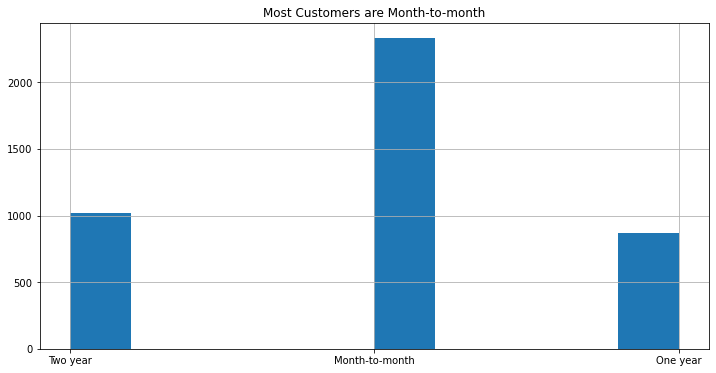

In [62]:
# which contract type is most common?
plt.figure(figsize=(12, 6))
plt.title('Most Customers are Month-to-month')
train.contract_type.hist()
plt.show()


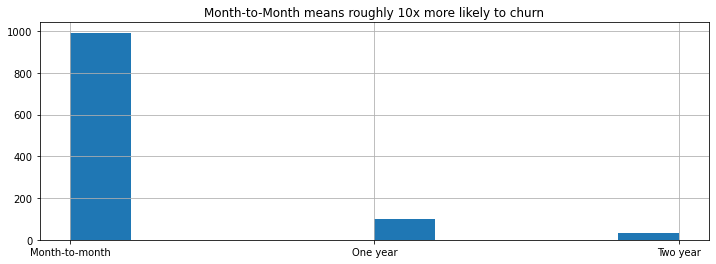

In [74]:
# which contract type churns most often?
plt.figure(figsize=(12, 4))
train.contract_type.where(train.churn == 'Yes').hist()
plt.title('Month-to-Month means roughly 10x more likely to churn')
plt.show()

Text(0.5, 1.0, 'Month-to-month customers who churn, make up nearly 25% of all customers.')

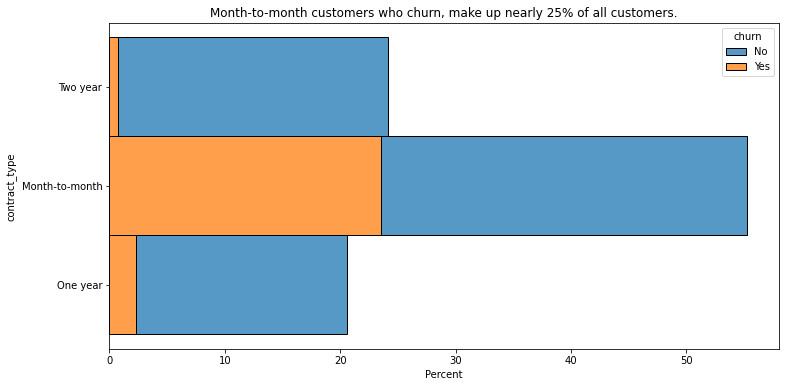

In [66]:
plt.figure(figsize=(12, 6))
sns.histplot(data=train, y='contract_type',multiple='stack', stat='percent',hue='churn')
plt.title("Month-to-month customers who churn, make up nearly 25% of all customers.")

Text(0.5, 1.0, 'E-check makes up over 50% of all churn')

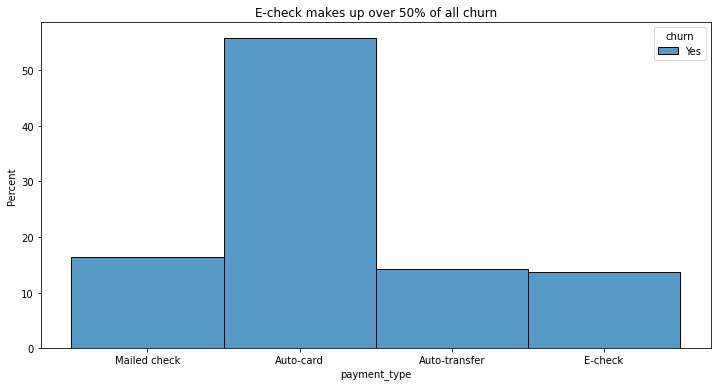

In [81]:
plt.figure(figsize=(12, 6))
sns.histplot(data=train.where(train.churn=='Yes'), x='payment_type',multiple='stack', stat='percent',hue='churn')
plt.xticks([0,1,2,3],['Mailed check','Auto-card','Auto-transfer','E-check'])
plt.title('E-check makes up over 50% of all churn')


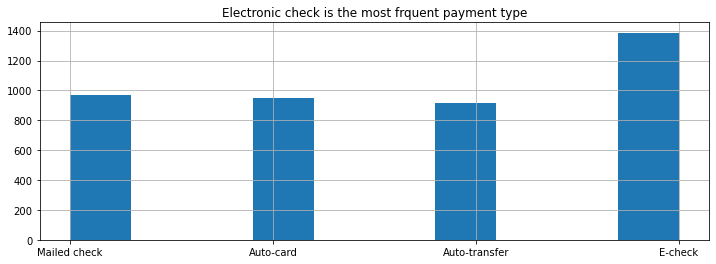

In [82]:
plt.figure(figsize=(12, 4))
plt.title('Electronic check is the most frquent payment type')
train.payment_type.hist()
plt.xticks([0,1,2,3],['Mailed check','Auto-card','Auto-transfer','E-check'])
plt.show()

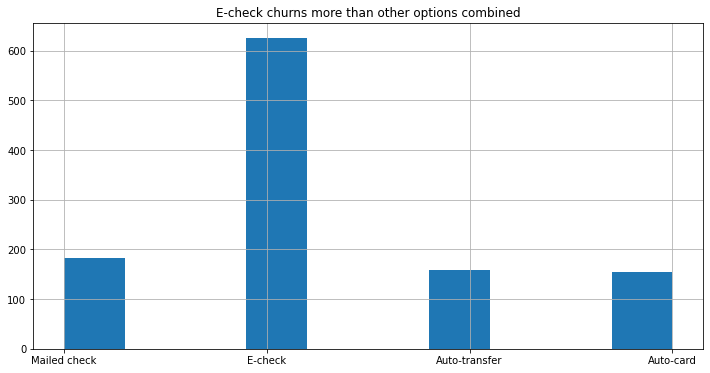

In [70]:
# which payment type churns most often?
plt.figure(figsize=(12, 6))
train.payment_type.where(train.churn == 'Yes').hist()
plt.title('E-check churns more than other options combined')
plt.xticks([0,1,2,3],['Mailed check','E-check','Auto-transfer','Auto-card'])
plt.show()

In [17]:
# checking to see if streaming services are connected
pd.crosstab(train.streaming_tv,train.streaming_movies)

streaming_movies,No,No internet service,Yes
streaming_tv,,,
No,1196,0,471
No internet service,0,930,0
Yes,445,0,1176


In [18]:
# checking to see if paperless billing correlates with churn
pd.crosstab(train.paperless_billing, train.churn)

churn,No,Yes
paperless_billing,,
No,1445,288
Yes,1652,833


In [19]:
# checking which payment method has the most churn
pd.crosstab(train.churn, train.payment_type)
# E-check has the most churn

payment_type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
churn,,,,
No,756,797,761,783
Yes,159,154,625,183


In [20]:
# checking which contract type churns most
pd.crosstab(train.churn, train.contract_type)
# month to month has the most churn by far

contract_type,Month-to-month,One year,Two year
churn,,,
No,1339,771,987
Yes,992,98,31


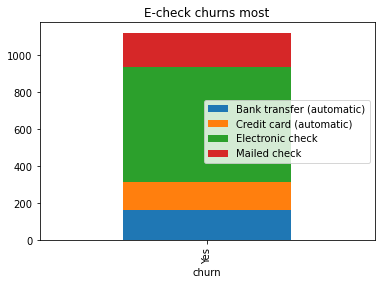

In [21]:
payment_ct = pd.crosstab(train.churn.where(train.churn == 'Yes'), train.payment_type)
payment_ct.plot(kind='bar', stacked = True)
plt.title('E-check churns most')
plt.legend()

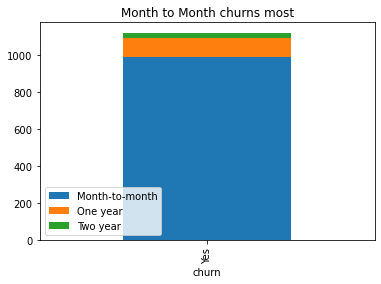

In [22]:
contract_ct = pd.crosstab(train.churn.where(train.churn == 'Yes'), train.contract_type)
contract_ct.plot(kind='bar', stacked = True)
plt.title('Month to Month churns most')
plt.legend()

In [23]:
# what is the most common payment_type/contract_type combo?
pd.crosstab(train.payment_type,train.contract_type)
# the most common payment/contract combo is E-check/month-to-month

contract_type,Month-to-month,One year,Two year
payment_type,,,
Bank transfer (automatic),354,240,321
Credit card (automatic),347,240,364
Electronic check,1085,202,99
Mailed check,545,187,234


Text(0.5, 1.0, 'Month-to-Month costs more on average')

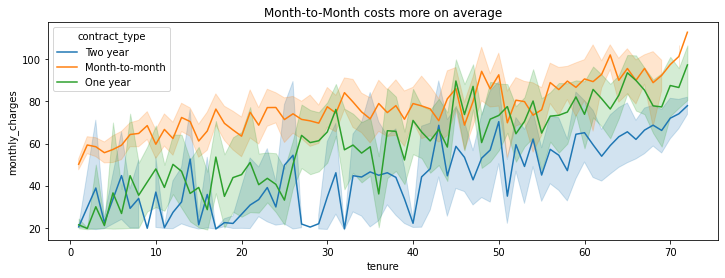

In [76]:
# which contract type costs more?
plt.figure(figsize=(12, 4))
sns.lineplot(data=train, y='monthly_charges',x='tenure',hue='contract_type')
plt.title('Month-to-Month costs more on average')

<AxesSubplot:xlabel='tenure', ylabel='monthly_charges'>

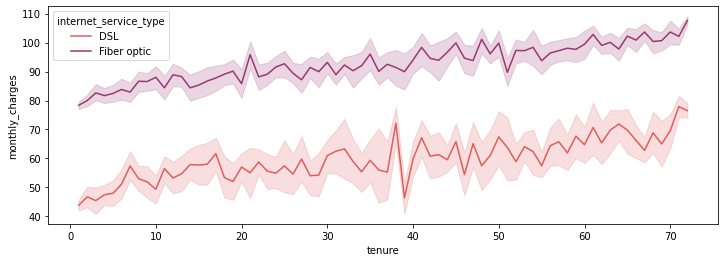

In [78]:
# which internet service costs more?
plt.figure(figsize=(12, 4))
sns.lineplot(data=train.where(train.internet_service_type!='None'), y='monthly_charges',x='tenure',hue='internet_service_type', palette='flare')


<AxesSubplot:xlabel='tenure', ylabel='monthly_charges'>

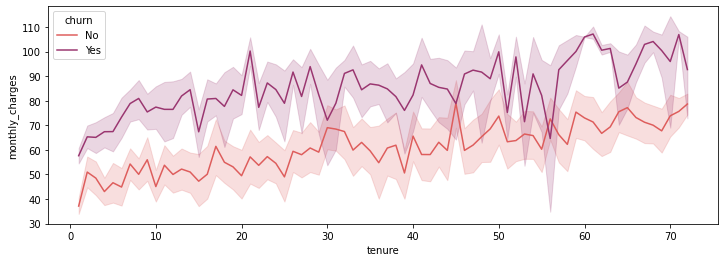

In [79]:
# do people who churn consistently pay more?
plt.figure(figsize=(12, 4))
sns.lineplot(data=train, y='monthly_charges',x='tenure',hue='churn', palette='flare')


<AxesSubplot:xlabel='payment_type', ylabel='monthly_charges'>

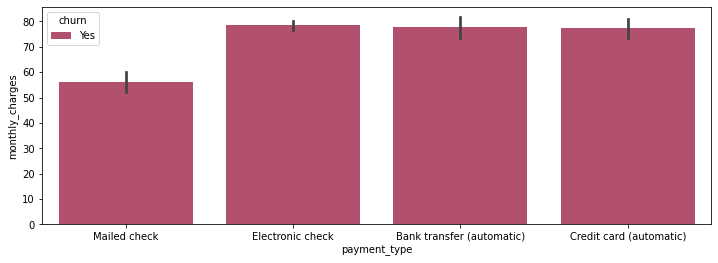

In [90]:
# do people who pay by e-check consistently pay more?
plt.figure(figsize=(12, 4))
sns.barplot(data=train.where(train.churn=='Yes'), y='monthly_charges',x='payment_type',hue='churn', palette='flare')


### hypothesis testing

H0 = variable and churn are independent

Ha = variable and churn are dependent

alpha = .05

In [27]:
# i created a loop to cycle through each variable in the data set to determine which, if any, 
# dont meet the criteria to be considered dependent.

def important_variables(train):
    a = .05
    for variable in train:
    # we are checking each of the categorical variables for a dependent relationship with churn by using the chi^2
    # test. a p-score lower than .05 means the variable are likely statistically dependent.
        if train[variable].dtype == 'O':
            contract_churn = pd.crosstab(train[variable], train.churn)
            chi2, p, degf, expected = stats.chi2_contingency(contract_churn)
            chi2, p

            if p > a:
                print(f'{variable} and churn are NOT dependent.')
                
    # all of the continuous variable with the float64 type are ones where we want to know if the value
    # is higher for people who churn. so we are using a 1 tailed t-test, and looking for a t-score above 0
        elif train[variable].dtype == 'float64':
            churn_sample = train[train.churn == 'Yes'][variable]
            overall_mean = train[variable].mean()

            t, p = stats.ttest_1samp(churn_sample, overall_mean)
       
            if (p/2) > a:
                print(f'{variable} is NOT HIGHER for people who churn.')
            elif t<0:
                print(f'{variable} is NOT HIGHER for people who churn.')
            else:
                print(f'{variable} is HIGHER for people who churn. Confidence level: {1-(p/2)}')
    # tenure is the only variable left with the int64 type, and 
    # is also the only variable where we want to see if its value is lower for people who churn.
    # so we are still doing a 1-tailed t-test, but now we are looking for a t-score below 0
        elif train[variable].dtype == 'int64':
            churn_sample = train[train.churn == 'Yes'][variable]
            overall_mean = train[variable].mean()
            
            t,p = stats.ttest_1samp(churn_sample, overall_mean)
            
            if (p/2) > a:
                print(f'{variable} is NOT LOWER for people who churn.')
            elif t>0:
                print(f'{variable} is NOT LOWER for people who churn.')
            else:
                print(f'{variable} is LOWER for people who churn. Confidence level: {1-(p/2)}')
                

In [28]:
important_variables(train)

customer_id and churn are NOT dependent.
tenure is LOWER for people who churn. Confidence level: 1.0
phone_service and churn are NOT dependent.
monthly_charges is HIGHER for people who churn. Confidence level: 1.0
total_charges is NOT HIGHER for people who churn.


In [29]:
# here i am dropping the statistically unimportant variables. i am only dropping the phone service dummy 
# because phone_service is dropped in the next step.

train = train.drop(columns=['phone_service_Yes','total_charges'])
validate = validate.drop(columns=['phone_service_Yes','total_charges'])
test = test.drop(columns=['phone_service_Yes','total_charges'])

### modeling

In [30]:
# 
train = train.drop(columns=dummy_list)
validate = validate.drop(columns=dummy_list)
test = test.drop(columns=dummy_list)
    

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4218 entries, 3727 to 1002
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customer_id                            4218 non-null   object 
 1   tenure                                 4218 non-null   int64  
 2   monthly_charges                        4218 non-null   float64
 3   churn                                  4218 non-null   object 
 4   paperless_billing_Yes                  4218 non-null   uint8  
 5   online_security_No internet service    4218 non-null   uint8  
 6   online_security_Yes                    4218 non-null   uint8  
 7   online_backup_No internet service      4218 non-null   uint8  
 8   online_backup_Yes                      4218 non-null   uint8  
 9   device_protection_No internet service  4218 non-null   uint8  
 10  device_protection_Yes                  4218 non-null   uint8  
 11  s

In [32]:
predictions = pd.DataFrame(test.customer_id.reset_index())


x_train = train.drop(columns=['churn','customer_id'])
y_train = train.churn

x_validate = validate.drop(columns=['churn', 'customer_id'])
y_validate = validate.churn

x_test = test.drop(columns=['churn', 'customer_id'])
y_test = test.churn

### random forest model

In [33]:

RF1 = RandomForestClassifier(min_samples_leaf= 10, max_depth=10, random_state = 123)
RF1.fit(x_train,y_train)
y_pred = RF1.predict(x_train)
# according to this model, tenure, and Fiber_optic internet are most important when predicting churn
print(RF1.feature_importances_)


[0.28570235 0.10951521 0.01836683 0.01409133 0.06156547 0.00933351
 0.01491439 0.01478597 0.01461858 0.01075709 0.00871449 0.01593673
 0.00974821 0.0047266  0.01162836 0.00995614 0.03230766 0.04941392
 0.09473122 0.11289963 0.01927562 0.01207333 0.05772631 0.00721107]


In [34]:
print(RF1.score(x_train,y_train))
print(classification_report(y_train, y_pred))


0.8186344238975818
              precision    recall  f1-score   support

          No       0.85      0.92      0.88      3097
         Yes       0.71      0.54      0.61      1121

    accuracy                           0.82      4218
   macro avg       0.78      0.73      0.75      4218
weighted avg       0.81      0.82      0.81      4218



### decision tree model

              precision    recall  f1-score   support

          No       0.81      0.93      0.87      3097
         Yes       0.69      0.41      0.51      1121

    accuracy                           0.79      4218
   macro avg       0.75      0.67      0.69      4218
weighted avg       0.78      0.79      0.77      4218



[Text(558.0, 713.475, 'tenure <= 17.5\ngini = 0.39\nsamples = 4218\nvalue = [3097, 1121]\nclass = No'),
 Text(279.0, 509.625, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.497\nsamples = 1570\nvalue = [850, 720]\nclass = No'),
 Text(139.5, 305.775, 'tenure <= 5.5\ngini = 0.411\nsamples = 910\nvalue = [647, 263]\nclass = No'),
 Text(69.75, 101.92499999999995, 'gini = 0.483\nsamples = 496\nvalue = [294, 202]\nclass = No'),
 Text(209.25, 101.92499999999995, 'gini = 0.251\nsamples = 414\nvalue = [353, 61]\nclass = No'),
 Text(418.5, 305.775, 'tenure <= 1.5\ngini = 0.426\nsamples = 660\nvalue = [203, 457]\nclass = Yes'),
 Text(348.75, 101.92499999999995, 'gini = 0.224\nsamples = 140\nvalue = [18, 122]\nclass = Yes'),
 Text(488.25, 101.92499999999995, 'gini = 0.458\nsamples = 520\nvalue = [185, 335]\nclass = Yes'),
 Text(837.0, 509.625, 'internet_service_type_Fiber optic <= 0.5\ngini = 0.257\nsamples = 2648\nvalue = [2247, 401]\nclass = No'),
 Text(697.5, 305.775, 'contract_type_Two ye

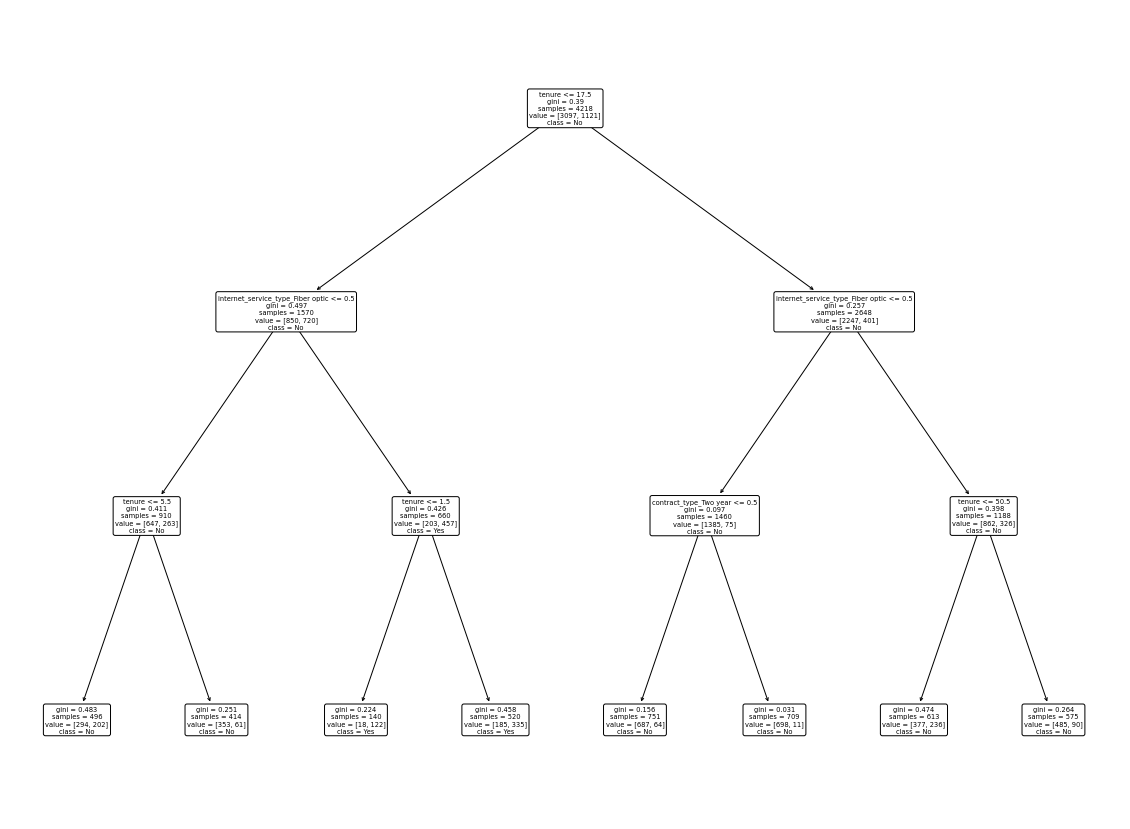

In [35]:
dt = DecisionTreeClassifier(max_depth=3, random_state = 123)
dt.fit(x_train,y_train)
y_pred= dt.predict(x_train)
print(classification_report(y_train, y_pred))


plt.figure(figsize=(20, 15))
plot_tree(dt, feature_names=x_train.columns, class_names=dt.classes_, rounded=True)



### k nearest neighbor

In [36]:
knn = KNeighborsClassifier(n_neighbors=6, weights='uniform')
knn.fit(x_train,y_train)
y_pred = knn.predict(x_train)

In [37]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

          No       0.84      0.95      0.89      3097
         Yes       0.77      0.50      0.61      1121

    accuracy                           0.83      4218
   macro avg       0.80      0.72      0.75      4218
weighted avg       0.82      0.83      0.81      4218



### looping through models

In [38]:
  
    performance=[]
    for i in range(1,21):
        model = RandomForestClassifier(min_samples_leaf=5, max_depth=(21-i), random_state=123)
        model = model.fit(x_train,y_train)
        in_sample_accuracy = model.score(x_train, y_train)
        out_of_sample_accuracy = model.score(x_validate, y_validate)
        output = {
            "max_depth": (21-i),
            "train_accuracy": in_sample_accuracy,
            "validate_accuracy": out_of_sample_accuracy
        }
        performance.append(output)
    df = pd.DataFrame(performance)
    df["difference"] = df.train_accuracy - df.validate_accuracy

In [39]:
df

,max_depth,train_accuracy,validate_accuracy,difference
0,20,0.844239,0.791045,0.053194
1,19,0.845187,0.791045,0.054143
2,18,0.845187,0.790334,0.054853
3,17,0.844002,0.789623,0.054379
4,16,0.842817,0.796020,0.046797
5,15,0.843291,0.786780,0.056510
6,14,0.839497,0.790334,0.049163
7,13,0.841868,0.791045,0.050823
8,12,0.838786,0.794598,0.044188
9,11,0.833333,0.789623,0.043710


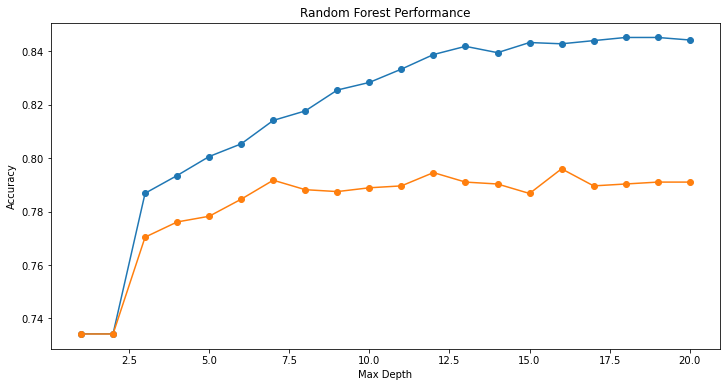

In [40]:

plt.figure(figsize=(12, 6))
plt.title('Random Forest Performance')
plt.plot(df.max_depth, df.train_accuracy, marker = 'o')
plt.plot(df.max_depth, df.validate_accuracy, marker = 'o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.show()

In [41]:
performance=[]
for i in range(1,21):
    model = KNeighborsClassifier(n_neighbors=i,weights='uniform')
    model = model.fit(x_train,y_train)
    in_sample_accuracy = model.score(x_train, y_train)
    out_of_sample_accuracy = model.score(x_validate, y_validate)
    output = {
        "max_depth": (21-i),
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    performance.append(output)
df = pd.DataFrame(performance)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,20,0.994547,0.721393,0.273154
1,19,0.869132,0.754087,0.115046
2,18,0.862731,0.746979,0.115752
3,17,0.840446,0.764748,0.075698
4,16,0.831437,0.773987,0.057449
5,15,0.827881,0.771144,0.056736
6,14,0.824561,0.771144,0.053417
7,13,0.819583,0.777541,0.042042
8,12,0.815789,0.779673,0.036116
9,11,0.812945,0.778962,0.033982


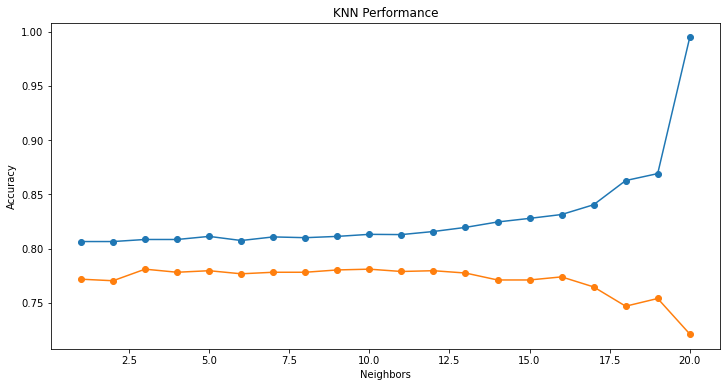

In [42]:

plt.figure(figsize=(12, 6))
plt.title('KNN Performance')
plt.plot(df.max_depth, df.train_accuracy, marker = 'o')
plt.plot(df.max_depth, df.validate_accuracy, marker = 'o')
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.show()

### Model Testing

The random forest model performed the best with min_samples_leaf set to 5 and max depth at 3

In [43]:
RF = RandomForestClassifier(min_samples_leaf=5, max_depth=6,random_state=123)
RF.fit(x_train,y_train)
y_proba = RF.predict_proba(x_test)
y_pred = RF.predict(x_test)
print(RF.score(x_test,y_test))

0.7967306325515281


In [44]:
x_train

,tenure,monthly_charges,paperless_billing_Yes,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,streaming_tv_No internet service,...,multiple_lines_Yes,tech_support_No internet service,tech_support_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
3727,45,20.35,0,1,0,1,0,1,0,1,...,0,1,0,0,1,0,1,0,0,1
4271,34,20.65,0,1,0,1,0,1,0,1,...,0,1,0,0,0,0,1,0,0,1
6317,15,19.45,1,1,0,1,0,1,0,1,...,0,1,0,0,0,0,1,1,0,0
489,12,61.65,1,0,1,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,1
3771,7,62.80,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3658,49,35.80,1,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
275,54,101.50,1,0,0,0,1,0,0,0,...,1,0,0,1,0,1,0,1,0,0
3465,1,94.60,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,1,0
3444,22,25.25,0,1,0,1,0,1,0,1,...,1,1,0,0,1,0,1,1,0,0


In [45]:
y_pred = pd.DataFrame(y_pred)
y_proba = pd.DataFrame(y_proba)

In [46]:
y_proba

,0,1
0,0.972306,0.027694
1,0.973556,0.026444
2,0.491557,0.508443
3,0.521005,0.478995
4,0.808642,0.191358
...,...,...
1402,0.792274,0.207726
1403,0.854649,0.145351
1404,0.731395,0.268605
1405,0.934495,0.065505


In [47]:

predictions = pd.concat([predictions,y_proba[1],y_pred],axis=1)
predictions.head()

,index,customer_id,1,0
0,3311,4716-MRVEN,0.027694,No
1,6330,8966-KZXXA,0.026444,No
2,6156,8720-RQSBJ,0.508443,Yes
3,5313,7504-UWHNB,0.478995,No
4,1176,1730-VFMWO,0.191358,No


In [48]:
predictions = predictions.drop(columns='index')
predictions.columns = ['customer_id','churn_proba','churn_pred']
predictions['churn_pred'] = predictions['churn_pred'].replace(['Yes','No'],[1,0])
predictions.to_csv('./predictions.csv',index=False)